# SANITY CHECK: Do I load the dimensions in fluctuation correctly?

In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5

data = np.load(os.path.join(f'{FLUCTUATION_PATH}/fluctuation', '1a4uB.npy'))

# data[0] means the first mode, data[0][1] means the first mode for the second residue, etc.
print(data[7][2]) # eighth mode of the third residue
print(sliding_window_view(data, WINDOW_SIZE, axis=1)[7][0]) # window between the first and fifth residue of the eighth mode
a = np.mean(sliding_window_view(data, WINDOW_SIZE, axis=1)[7][0]) # average the window between the first and fifth residue of the eighth mode
print(a)
b = sliding_window_view(data, WINDOW_SIZE, axis=1).mean(axis=2)[7][0] # compute the average of the window between the first and fifth residue of the eighth mode in a similar manner as above 
print(b)
assert a == b

8.203535185141722e-05
[7.25636372e-05 8.19505477e-05 8.20353519e-05 7.78313779e-05
 6.63055169e-05]
7.6137286304773e-05
7.6137286304773e-05


In [42]:
averaged_window_view = sliding_window_view(data, WINDOW_SIZE, axis=1).mean(axis=2)
averaged_window_view.shape # averaged_window_view[0] means first mode windows, averaged_window_view[0][0] means the first window of the first mode, etc
# therefore if I want to iterate over the modes, I need to write `for i, dimension in enumerate(averaged_window_view):` ...
averaged_window_view.transpose().shape # averaged_window_view[0] means first windows of all the modes 

(254, 250)

## Compute the sliding window over the fluctuation values

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5

def get_averaged_window_view(data, binding_input, nonbinding_input, indices):
    indices = indices - int(WINDOW_SIZE / 2)
    indices = indices[(indices >= 0) & (indices < (data.shape[0] - WINDOW_SIZE))] # for now, remove the 

    averaged_window_view = sliding_window_view(data, WINDOW_SIZE, axis=1).mean(axis=2)
    for i, dimension in enumerate(averaged_window_view):
        
        binding_values = np.take(dimension, indices)
        nonbinding_values = np.delete(dimension, indices)
        
        if len(binding_input) == i:
            binding_input.append(binding_values)
        elif len(binding_input) > i:
            binding_input[i] = np.concatenate((binding_input[i], binding_values))
        else:
            raise IndexError("This shouldn't happen")

        if len(nonbinding_input) == i:
            nonbinding_input.append(nonbinding_values)
        elif len(nonbinding_input) > i:
            nonbinding_input[i] = np.concatenate((nonbinding_input[i], nonbinding_values))
        else:
            raise IndexError("This shouldn't happen")



def compute_windows(reverse_modes=False, range=None):
    binding_fluctuation_dimensions, nonbinding_fluctuation_dimensions = [], []
    proteins_count = 0
    # Load data from the fluctuation folder
    for filename in os.listdir(f'{FLUCTUATION_PATH}/fluctuation'):
        # print(f'Processing {filename}')
        data = np.load(os.path.join(f'{FLUCTUATION_PATH}/fluctuation', filename))
        indices = np.load(os.path.join(f'{FLUCTUATION_PATH}/indices', filename))

        if range is not None:
            if len(data) < range[0] or len(data) > range[1]:
                continue
                
        if reverse_modes:
            data = np.flip(data, axis=0) # axis=0 means we are taking the modes (axis=1 would mean taking the residues)
        
        get_averaged_window_view(data, binding_fluctuation_dimensions, nonbinding_fluctuation_dimensions, indices)

        proteins_count += 1

    return binding_fluctuation_dimensions, nonbinding_fluctuation_dimensions, proteins_count


def print_barcharts(binding_data, nonbinding_data, title='', limit=None):
    # Compute median values for each position
    binding_medians = [np.median(data) for data in binding_data]
    nonbinding_medians = [np.median(data) for data in nonbinding_data]

    ylim = max(np.max(binding_medians), np.max(nonbinding_medians))
    # Generate histograms of median values for each position
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(221)
    plt.bar(range(0, len(binding_medians)), binding_medians, width=1.0, alpha=0.7, label='Binding')
    plt.title('Histogram of median values for each mode (Binding)')
    plt.xlabel('Mode')
    if limit:
        plt.ylim(0, limit)
    else:
        plt.ylim(0, ylim)
    plt.ylabel('Median Value')
    plt.legend()

    plt.subplot(222)
    plt.bar(range(0, len(nonbinding_medians)), nonbinding_medians, width=1.0, alpha=0.7, label='Nonbinding')
    plt.title('Histogram of vedian values for each mode (Nonbinding)')
    plt.xlabel('Mode')
    if limit:
        plt.ylim(0, limit)
    else:
        plt.ylim(0, ylim)
    plt.ylabel('Median Value')
    plt.legend()

    plt.subplot(212)
    plt.bar(list(range(0, len(binding_medians))), binding_medians, width=1.0, label='Binding', alpha=0.5)
    plt.bar(list(range(0, len(nonbinding_medians))), nonbinding_medians, width=1.0, label='Nonbinding', alpha=0.5)
    plt.title('Combined Histogram of Median Values')
    plt.xlabel('Mode')
    plt.ylabel('Median Value')
    if limit:
        plt.ylim(0, limit)
    else:
        plt.ylim(0, ylim)

    plt.legend()
    plt.tight_layout()
    plt.show()


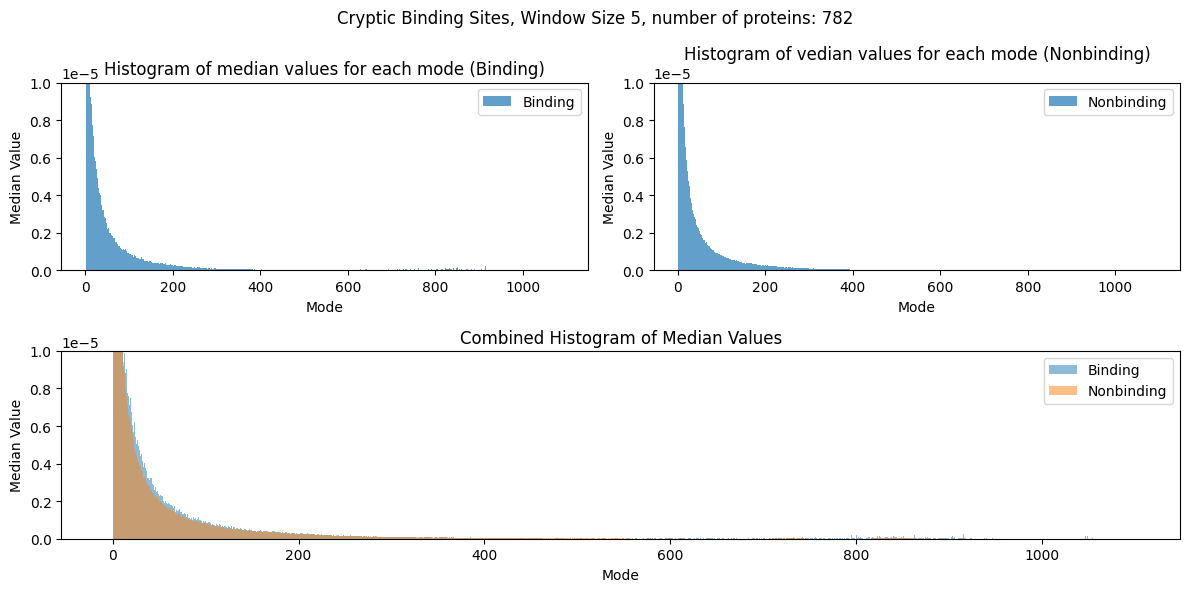

In [2]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows()
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.1e-4)

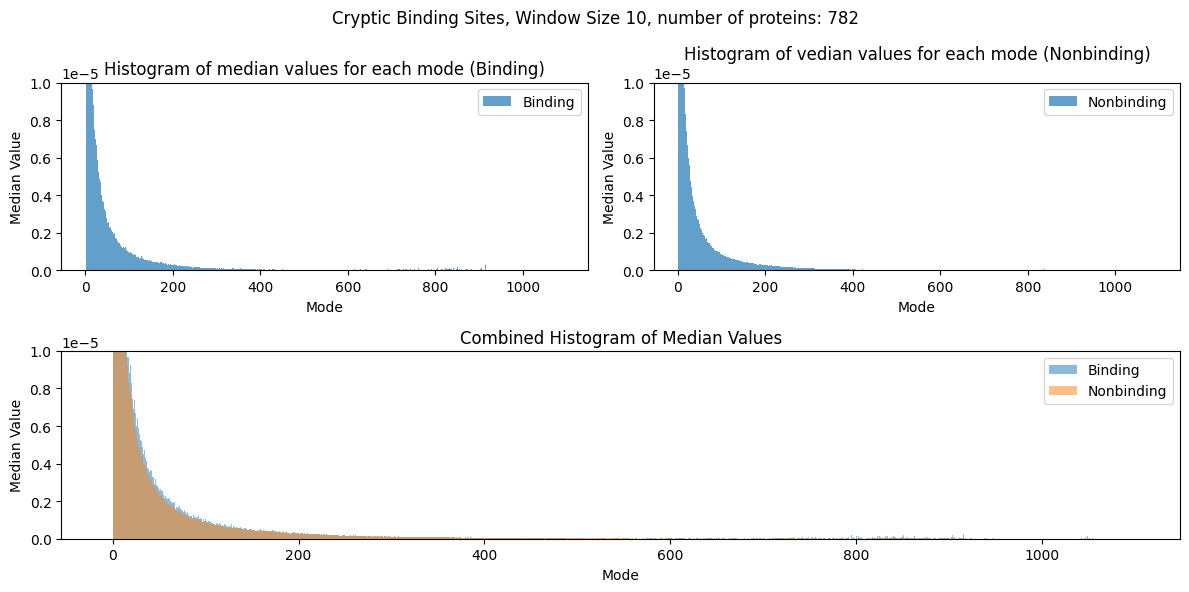

In [3]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 10
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows()
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 10, number of proteins: ' + str(count), limit=0.1e-4)

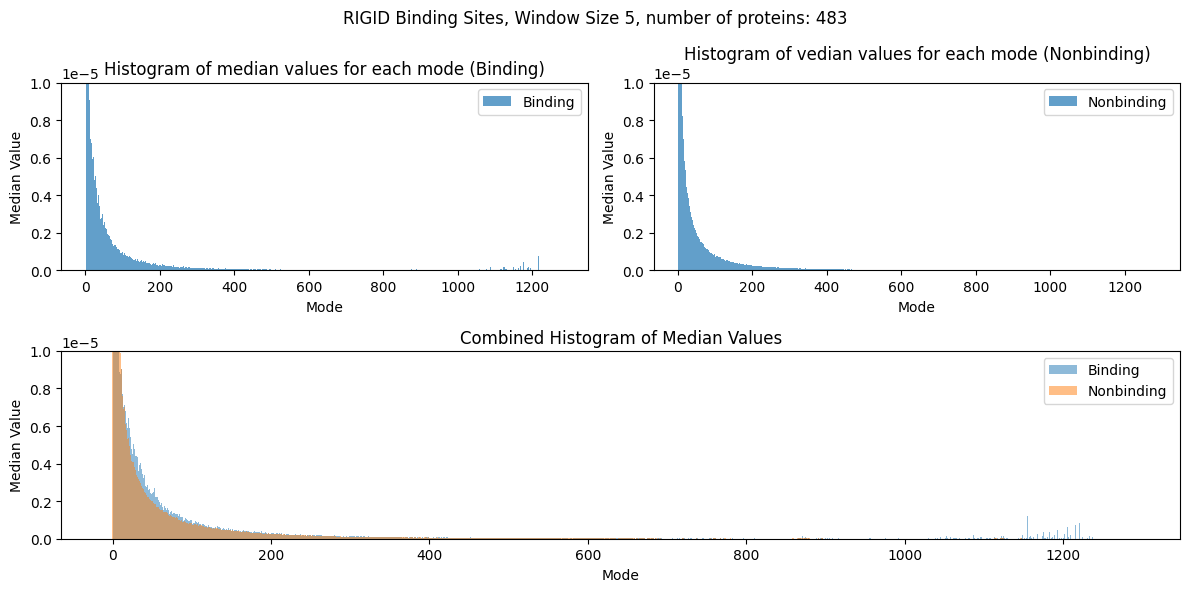

In [4]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows()
print_barcharts(binding_data_rigid, nonbinding_data_rigid, title='RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.1e-4)

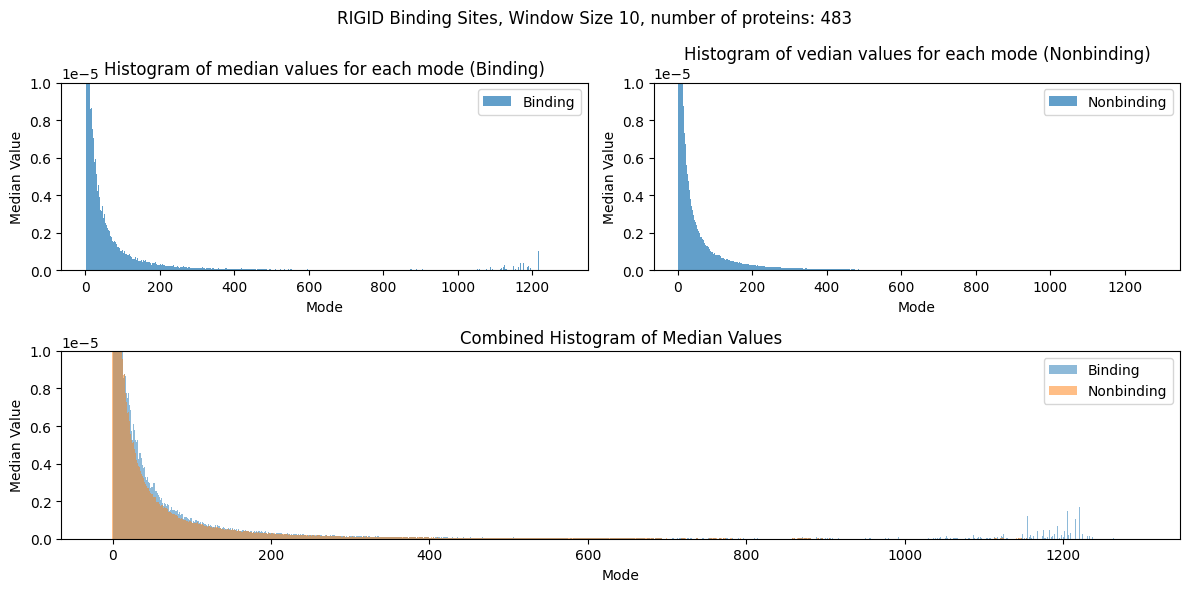

In [5]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 10
binding_data_rigid, nonbinding_data_rigid, count = compute_windows()
print_barcharts(binding_data_rigid, nonbinding_data_rigid, title='RIGID Binding Sites, Window Size 10, number of proteins: ' + str(count), limit=0.1e-4)

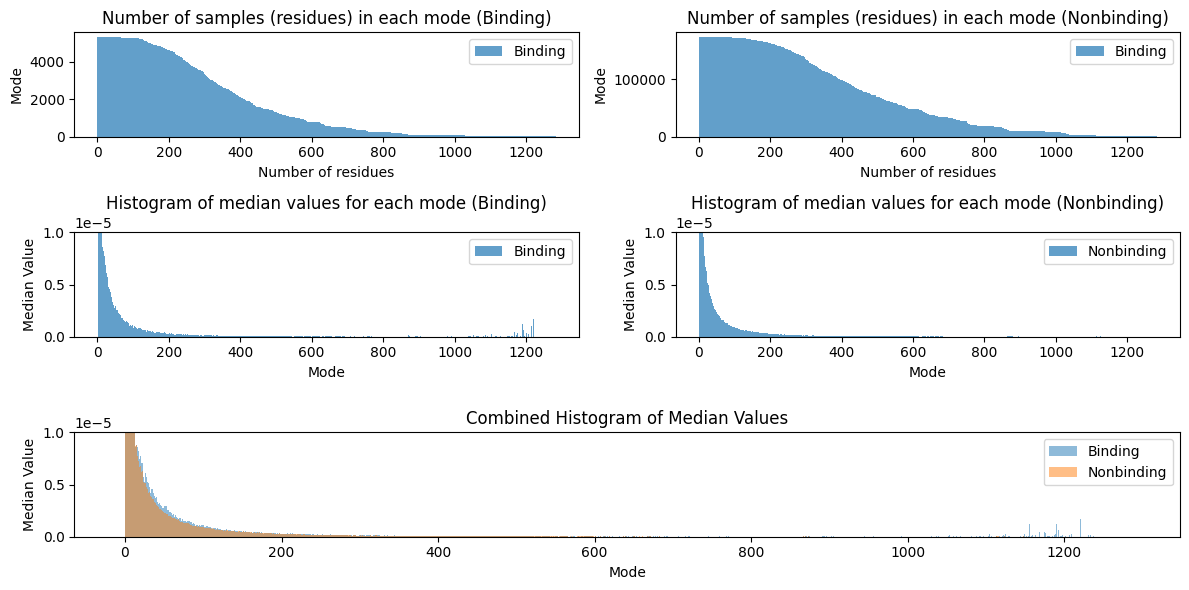

In [6]:
def print_barcharts_with_inset(binding_data, nonbinding_data, limit=None):
    # Compute median values for each position
    binding_medians = [np.median(data) for data in binding_data]
    nonbinding_medians = [np.median(data) for data in nonbinding_data]

    if limit:
        ylim = limit
    else:
        ylim = max(np.max(binding_medians), np.max(nonbinding_medians))

    # Generate histograms of median values for each position
    plt.figure(figsize=(12, 6))

    plt.subplot(3,2,1)
    plt.bar(range(0, len(binding_medians)), [len(data) for data in binding_data], width=1.0, alpha=0.7, label='Binding')
    plt.title('Number of samples (residues) in each mode (Binding)')
    plt.xlabel('Number of residues')
    plt.ylabel('Mode')
    plt.legend()

    plt.subplot(3,2,2)
    plt.bar(range(0, len(binding_medians)), [len(data) for data in nonbinding_data], width=1.0, alpha=0.7, label='Binding')
    plt.title('Number of samples (residues) in each mode (Nonbinding)')
    plt.xlabel('Number of residues')
    plt.ylabel('Mode')
    plt.legend()

    plt.subplot(3,2,3)
    plt.bar(range(0, len(binding_medians)), binding_medians, width=1.0, alpha=0.7, label='Binding')
    plt.title('Histogram of median values for each mode (Binding)')
    plt.xlabel('Mode')
    plt.ylim(0, ylim)
    plt.ylabel('Median Value')
    plt.legend()

    plt.subplot(3,2,4)
    plt.bar(range(0, len(nonbinding_medians)), nonbinding_medians, width=1.0, alpha=0.7, label='Nonbinding')
    plt.title('Histogram of median values for each mode (Nonbinding)')
    plt.xlabel('Mode')
    plt.ylim(0, ylim)
    plt.ylabel('Median Value')
    plt.legend()

    plt.subplot(3,1,3)
    plt.bar(list(range(0, len(binding_medians))), binding_medians, width=1.0, label='Binding', alpha=0.5)
    plt.bar(list(range(0, len(nonbinding_medians))), nonbinding_medians, width=1.0, label='Nonbinding', alpha=0.5)
    plt.title('Combined Histogram of Median Values')
    plt.xlabel('Mode')
    plt.ylabel('Median Value')
    plt.ylim(0, ylim)


    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function with the existing data
print_barcharts_with_inset(binding_data_rigid, nonbinding_data_rigid, limit=0.1e-4)

# TODO: improve this: neco takoveho by bylo lepsi, tohle je trochu random: https://www.google.com/search?q=matplotlib:%20plotting%20histogram%20plot%20just%20above%20scatter%20plot
# TODO: zkusit prevratit poradi tech modu, jestli to trba nebude vypadat lip

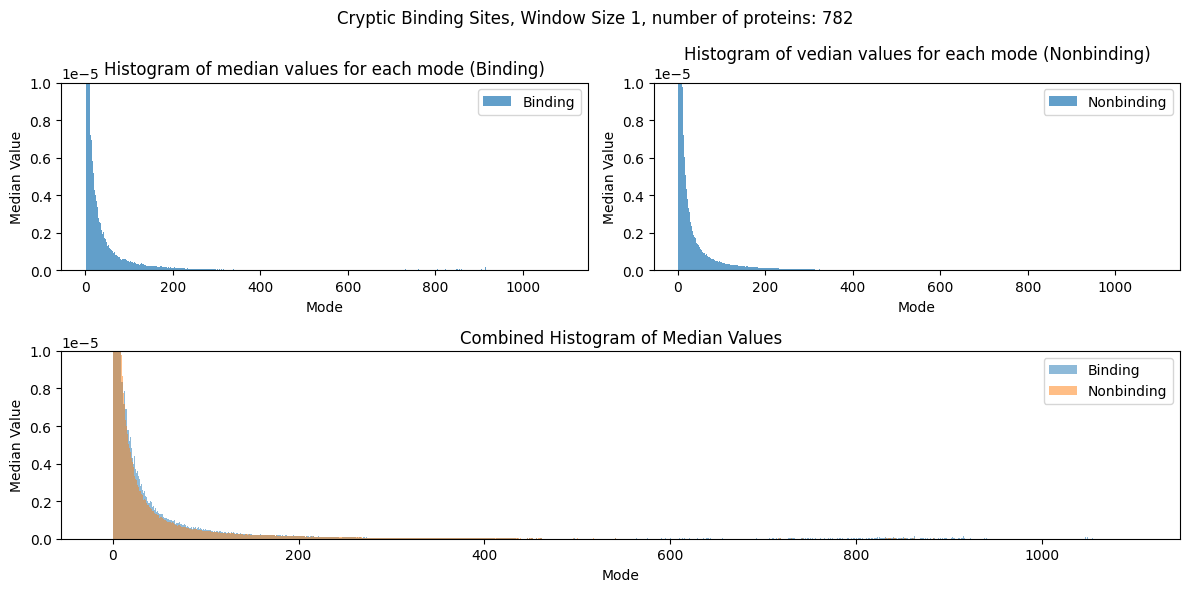

In [7]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 1
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows()
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 1, number of proteins: ' + str(count), limit=0.1e-4)

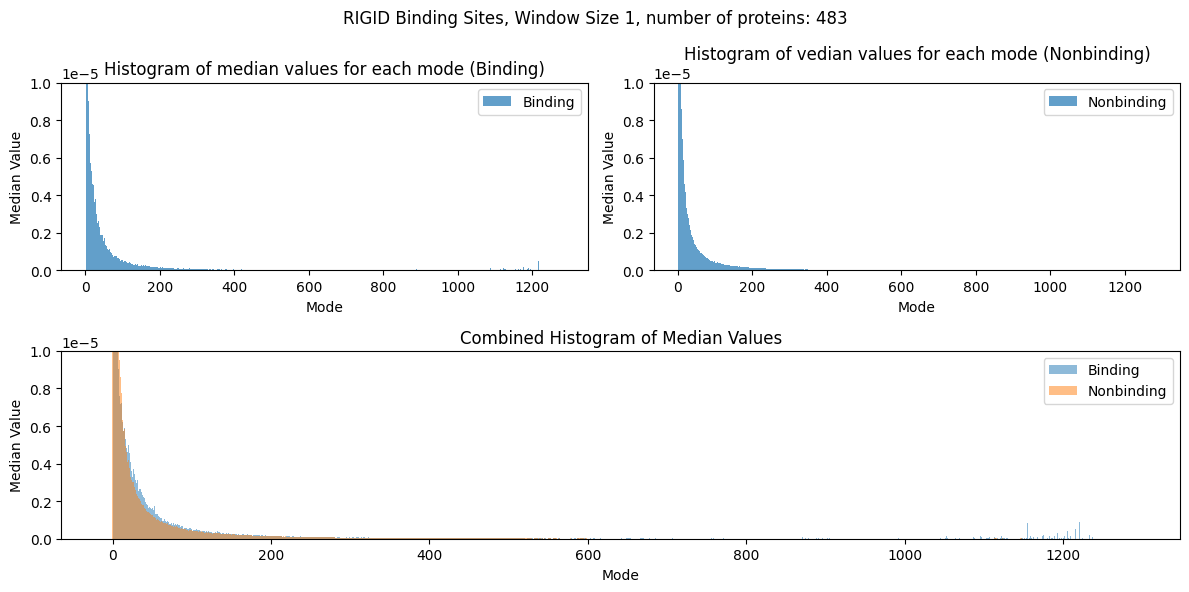

In [8]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 1
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows()
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='RIGID Binding Sites, Window Size 1, number of proteins: ' + str(count), limit=0.1e-4)

### Reverse the modes

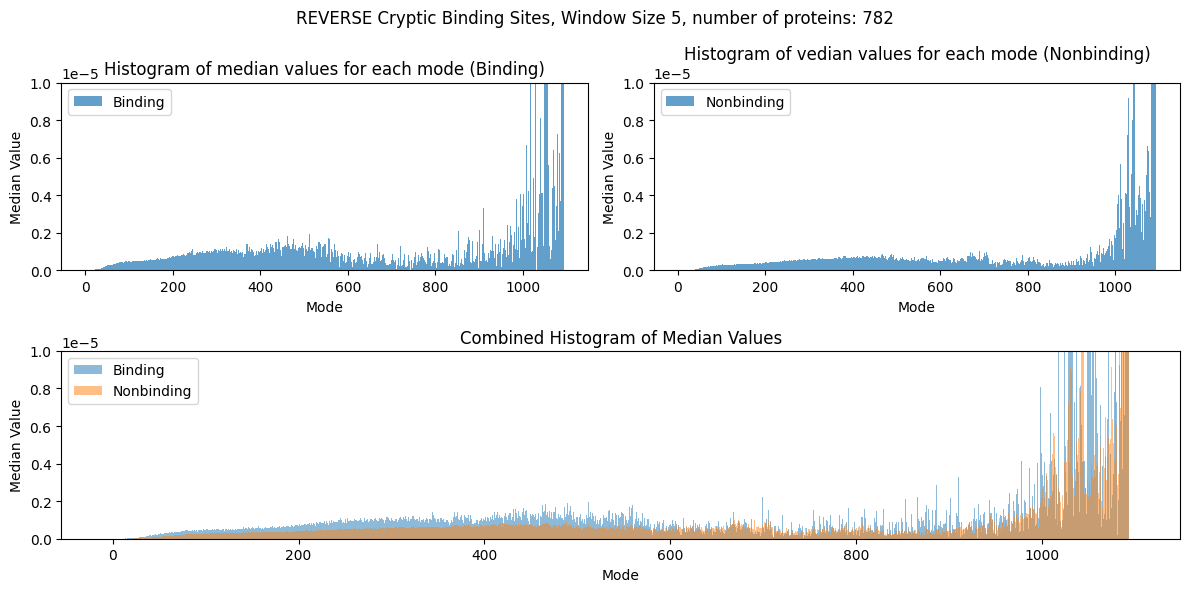

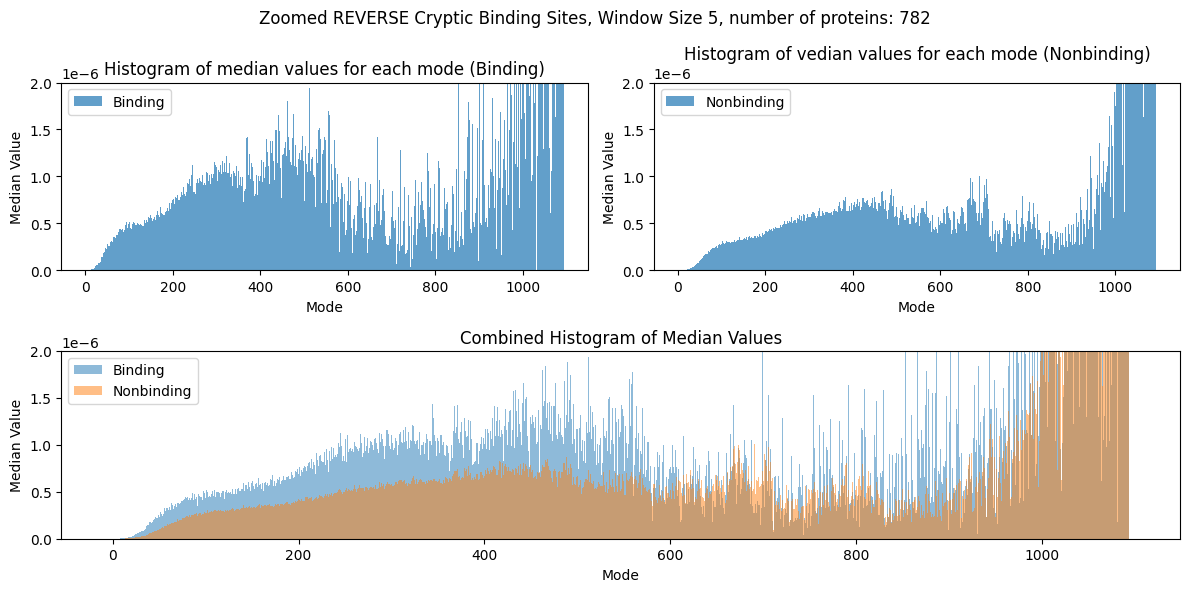

In [9]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(reverse_modes=True)
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='REVERSE Cryptic Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.1e-4)
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Zoomed REVERSE Cryptic Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.2e-5)

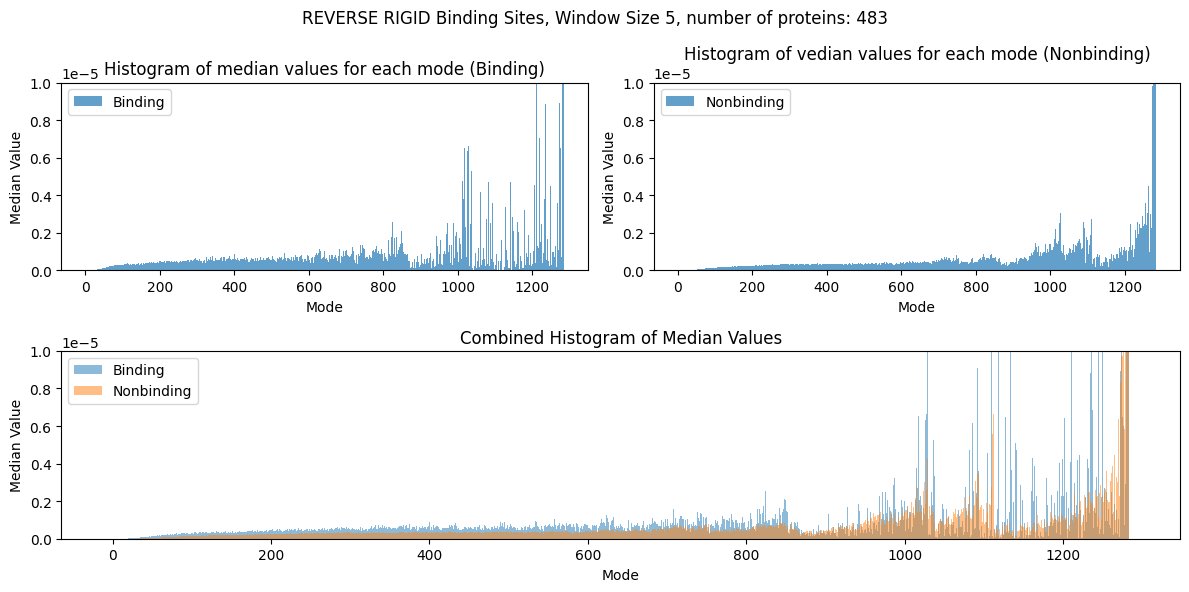

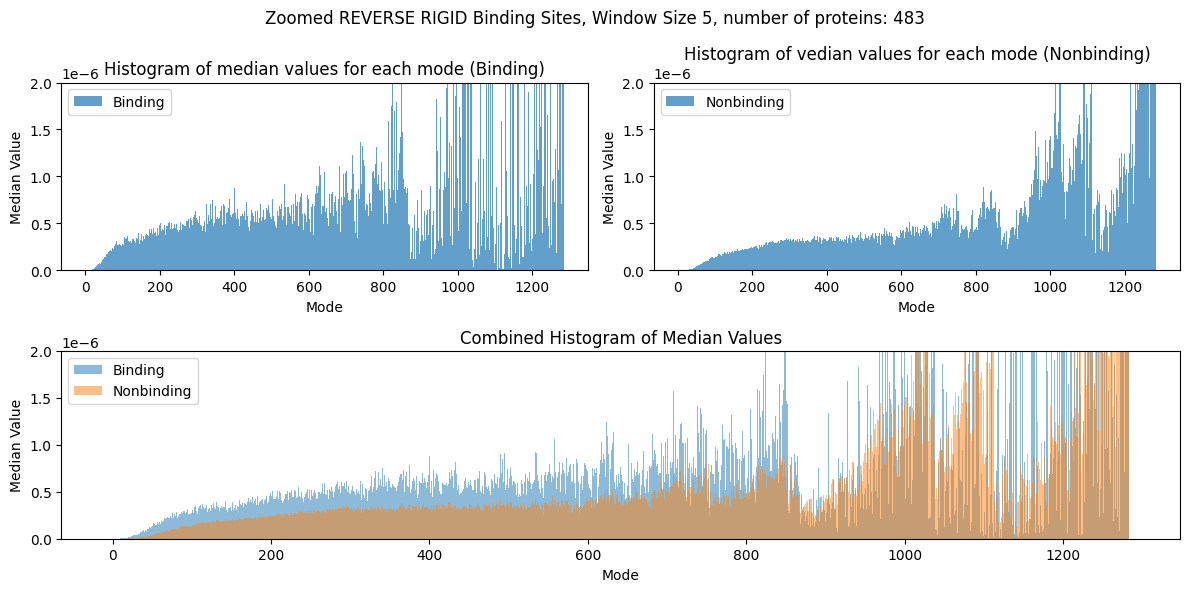

In [10]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True)
print_barcharts(binding_data_rigid, nonbinding_data_rigid, title='REVERSE RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.1e-4)
print_barcharts(binding_data_rigid, nonbinding_data_rigid, title='Zoomed REVERSE RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.2e-5)

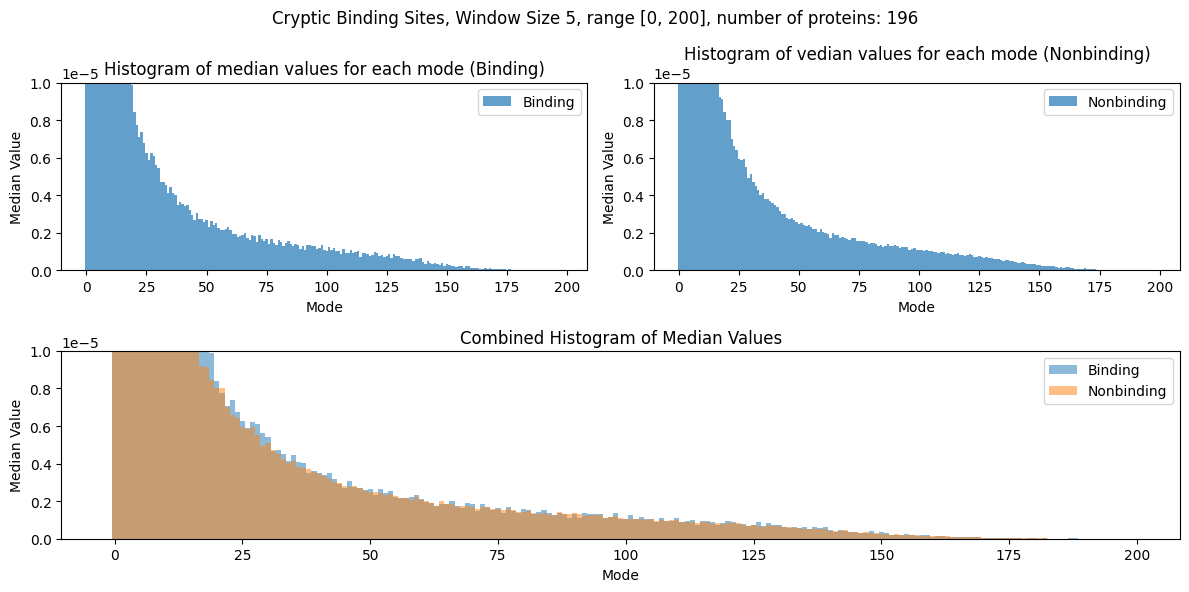

In [11]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(range=(0, 200))
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 5, range [0, 200], number of proteins: ' + str(count), limit=0.1e-4)

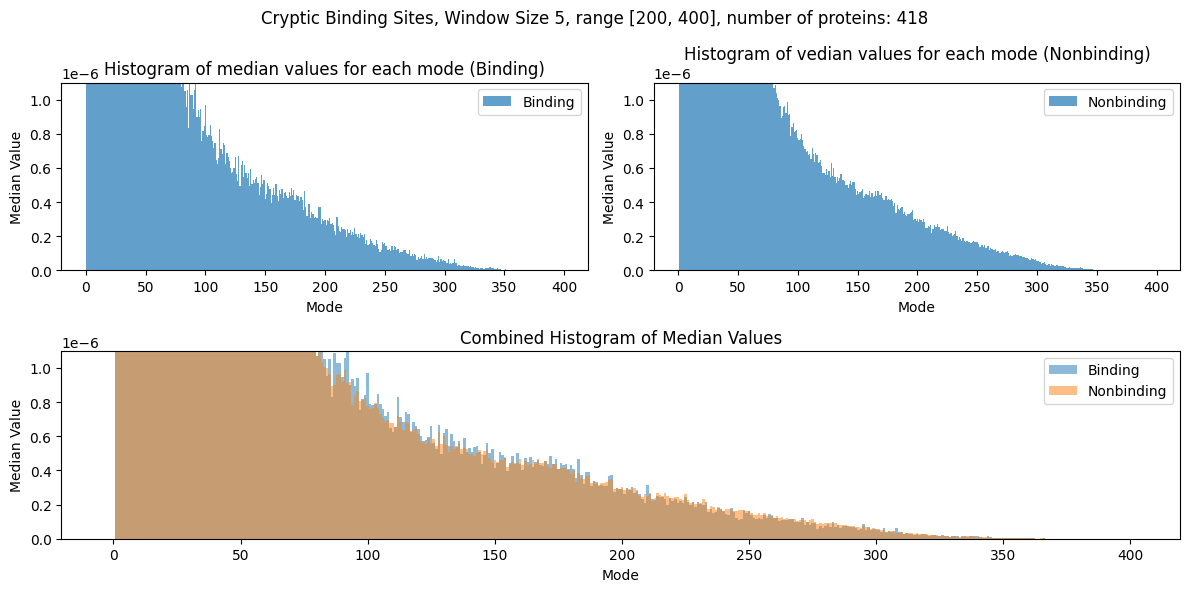

In [12]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(range=(200,400))
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 5, range [200, 400], number of proteins: ' + str(count), limit=1.1e-06)

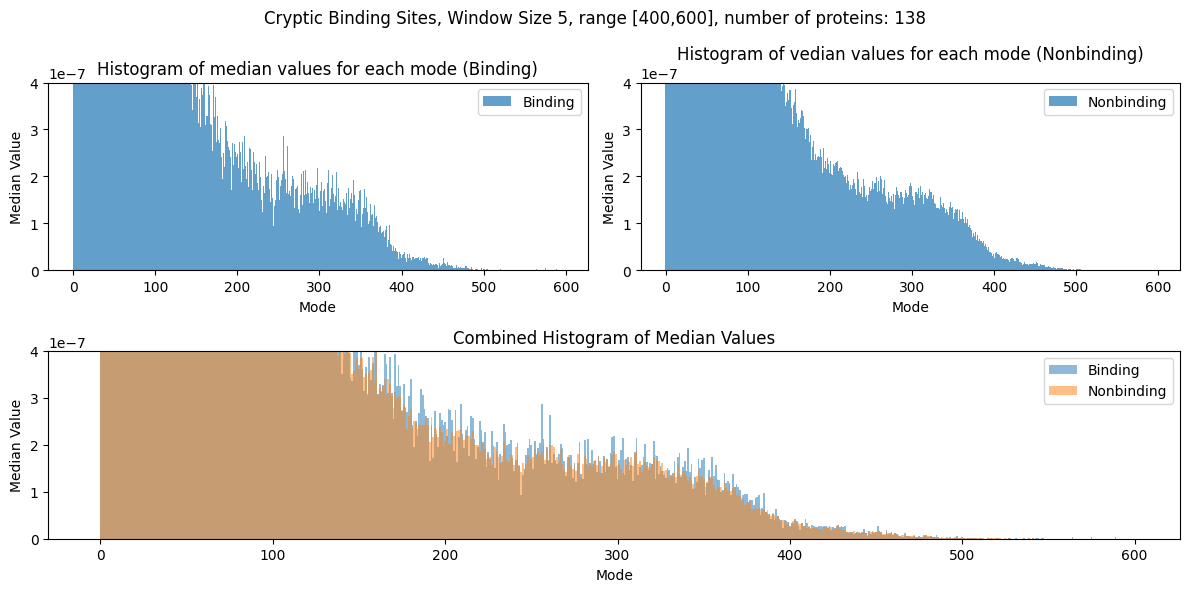

In [13]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(range=(400,600))
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 5, range [400,600], number of proteins: ' + str(count), limit=0.4e-06)

In [14]:
def print_barcharts_with_variance(binding_data, nonbinding_data, title='', limit=None):
    # Compute median values for each position
    binding_medians = [np.median(data) for data in binding_data]
    nonbinding_medians = [np.median(data) for data in nonbinding_data]

    ylim = max(np.max(binding_medians), np.max(nonbinding_medians))
    # Generate histograms of median values for each position
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(121)
    plt.bar(range(0, len(binding_medians)), binding_medians, width=1.0, alpha=0.7, label='Binding')

    upper_binding_variance = [np.percentile(data, 75) for data in binding_data]
    lower_binding_variance = [np.percentile(data, 25) for data in binding_data]
    plt.bar(range(0, len(lower_binding_variance)), lower_binding_variance, width=1.0, alpha=0.3, label='25 percentile')
    plt.bar(range(0, len(upper_binding_variance)), upper_binding_variance, width=1.0, alpha=0.3, label='75 percentile')

    plt.title('Histogram of median values for each mode (Binding)')
    plt.xlabel('Mode')
    if limit:
        plt.ylim(0, limit)
    else:
        plt.ylim(0, ylim)
    plt.ylabel('Median Value')
    plt.legend()


    plt.subplot(122)
    plt.bar(range(0, len(nonbinding_medians)), nonbinding_medians, width=1.0, alpha=0.7, label='Nonbinding')

    upper_nonbinding_variance = [np.percentile(data, 75) for data in nonbinding_data]
    lower_nonbinding_variance = [np.percentile(data, 25) for data in nonbinding_data]
    plt.bar(range(0, len(lower_nonbinding_variance)), lower_nonbinding_variance, width=1.0, alpha=0.3, label='25 percentile')
    plt.bar(range(0, len(upper_nonbinding_variance)), upper_nonbinding_variance, width=1.0, alpha=0.3, label='75 percentile')

    plt.title('Histogram of vedian values for each mode (Nonbinding)')
    plt.xlabel('Mode')
    if limit:
        plt.ylim(0, limit)
    else:
        plt.ylim(0, ylim)
    plt.ylabel('Median Value')
    plt.legend()


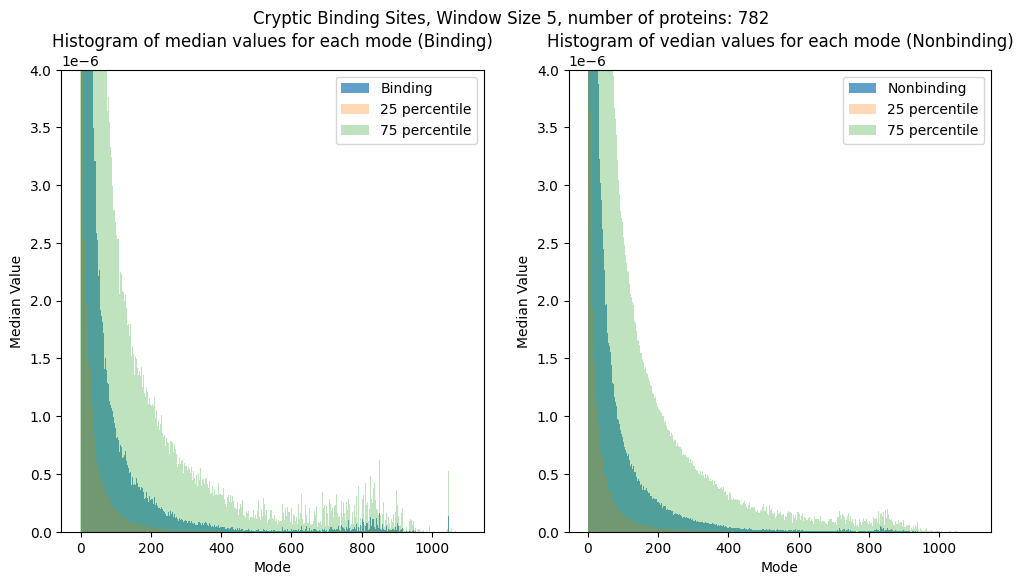

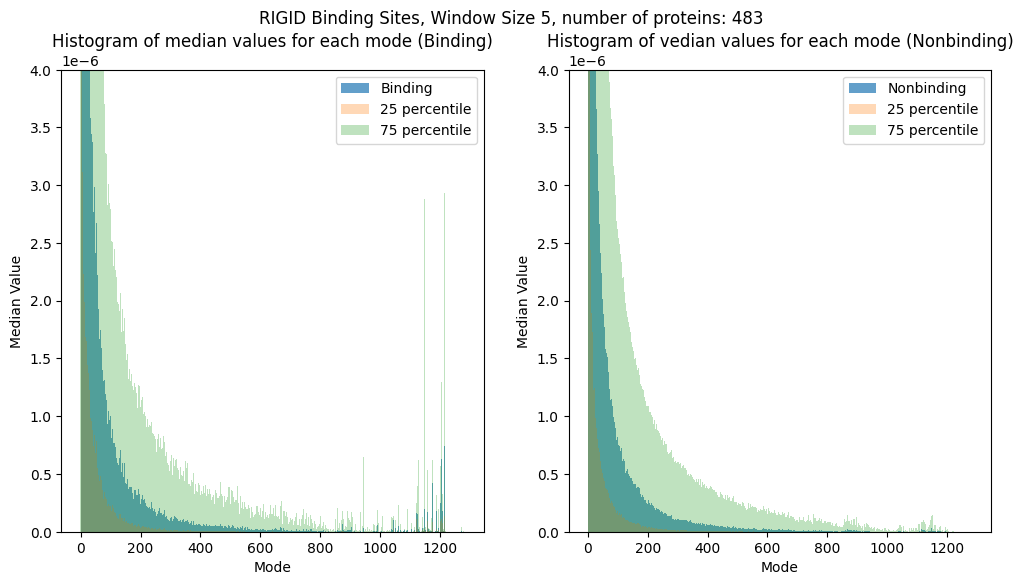

In [15]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows()
print_barcharts_with_variance(binding_data_cryptic, nonbinding_data_cryptic, title='Cryptic Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=4e-06)
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
binding_data_rigid, nonbinding_data_rigid, count = compute_windows()
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=4e-06)

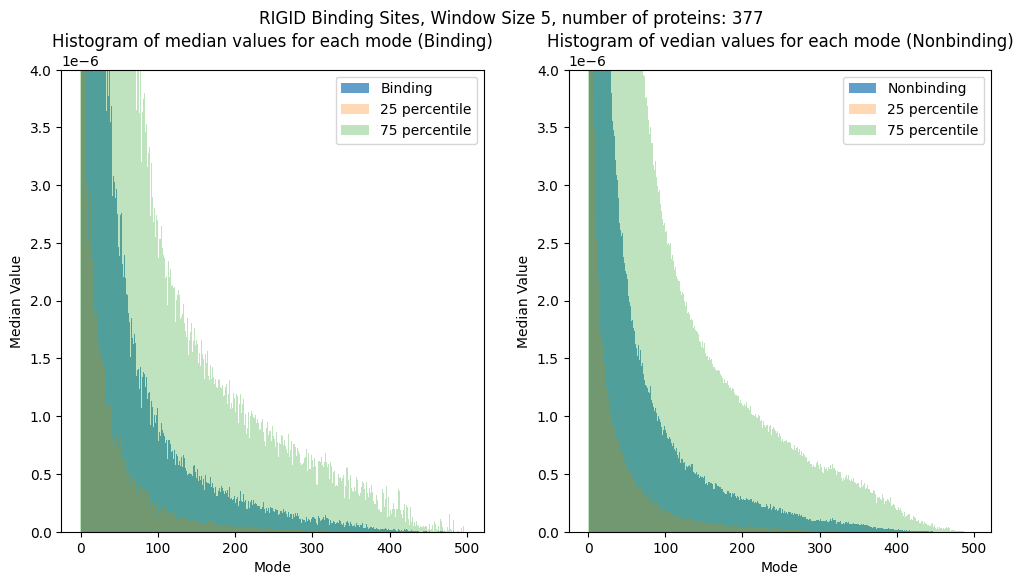

In [16]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(range=(0, 500))
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=4e-06)

Try this for the reversed mode order ...


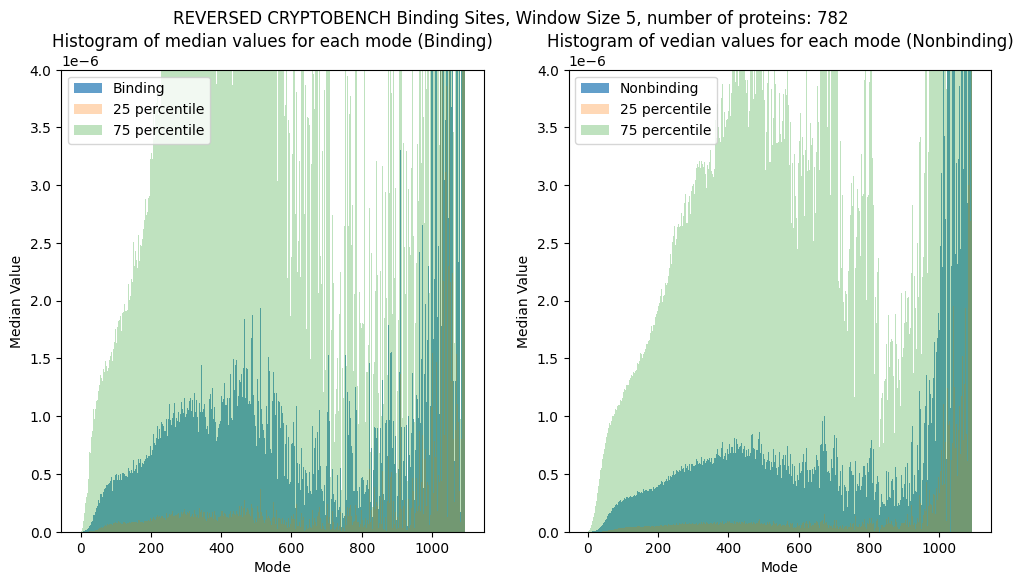

In [17]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True)
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='REVERSED CRYPTOBENCH Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=4e-06)

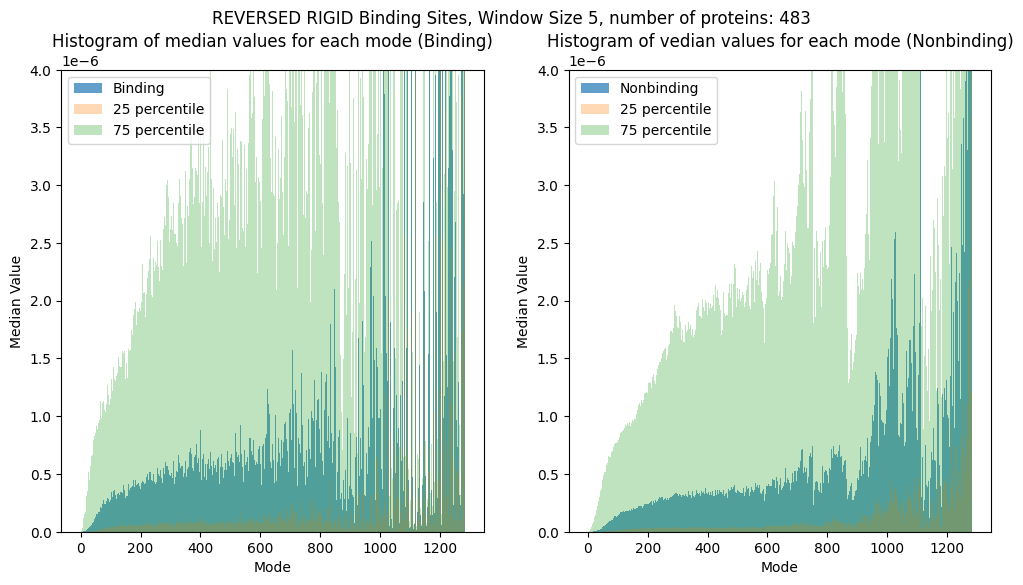

In [18]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True)
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='REVERSED RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=4e-06)

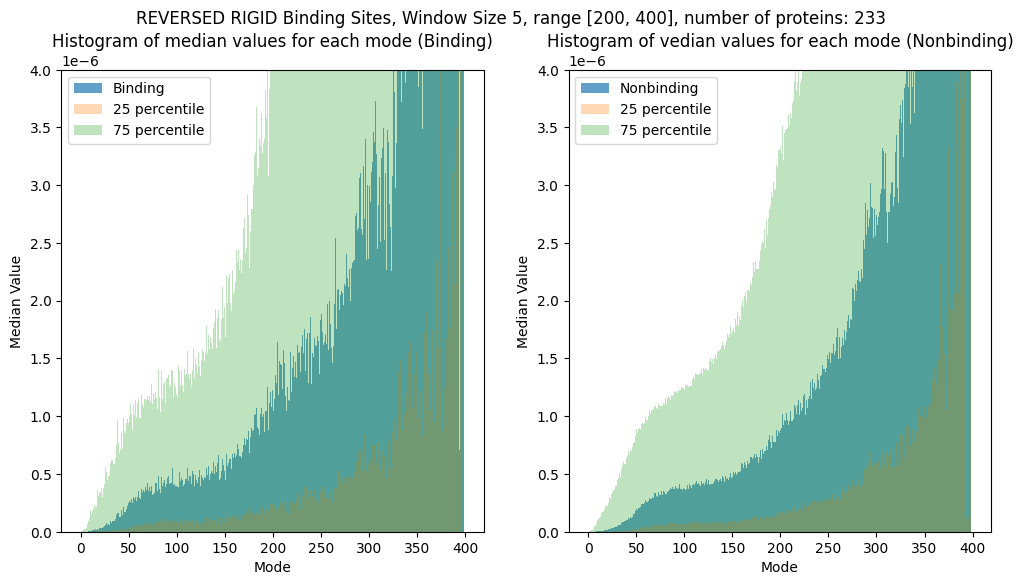

In [19]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True,range=(200, 400))
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='REVERSED RIGID Binding Sites, Window Size 5, range [200, 400], number of proteins: ' + str(count), limit=4e-06)

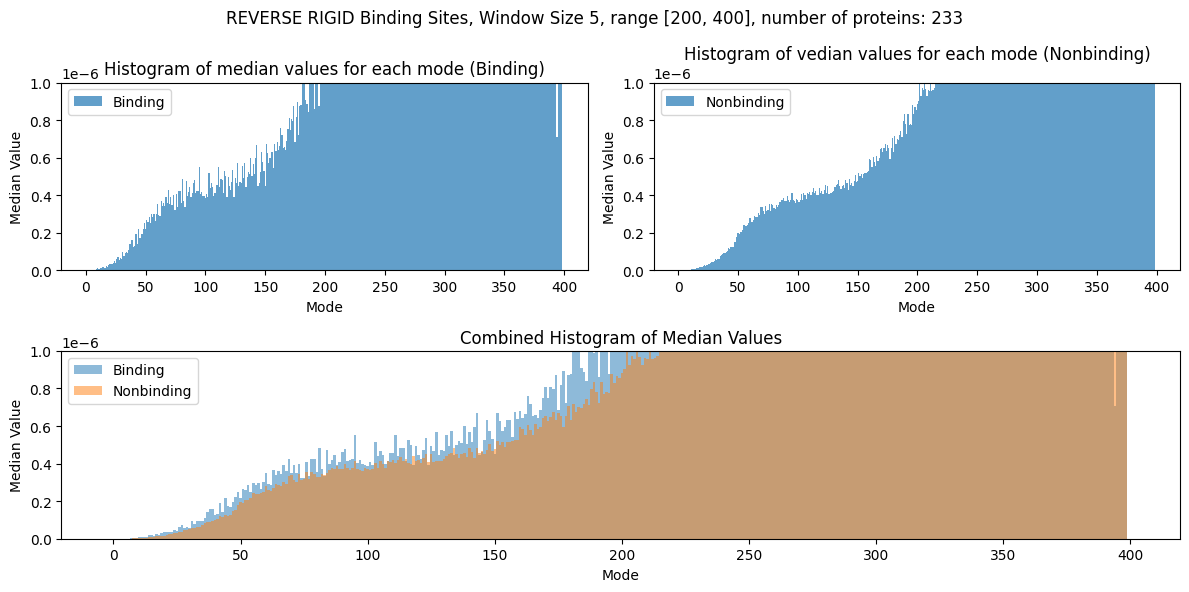

In [20]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(reverse_modes=True,range=(200, 400))
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='REVERSE RIGID Binding Sites, Window Size 5, range [200, 400], number of proteins: ' + str(count), limit=0.1e-05)

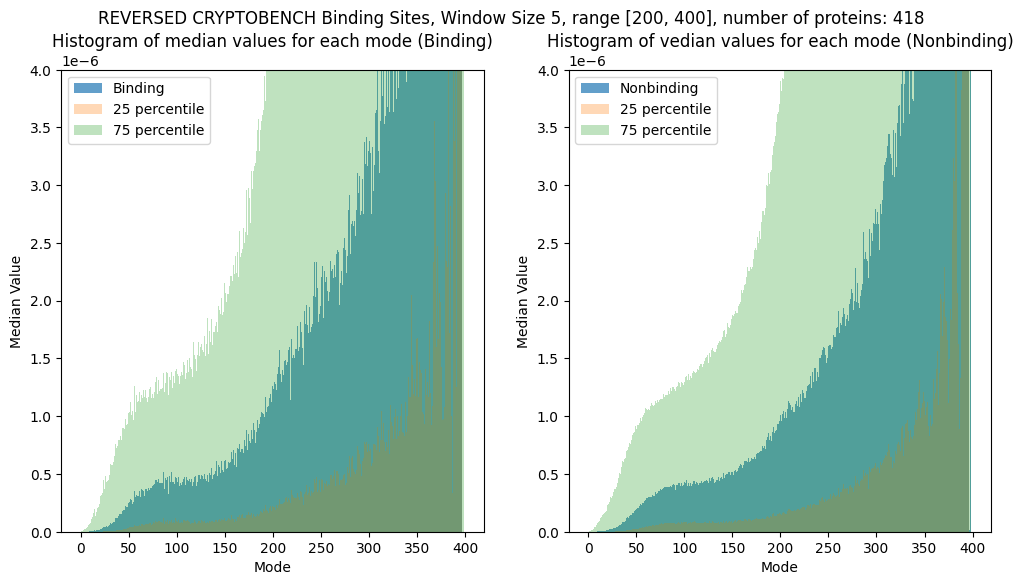

In [21]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True,range=(200, 400))
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='REVERSED CRYPTOBENCH Binding Sites, Window Size 5, range [200, 400], number of proteins: ' + str(count), limit=4e-06)

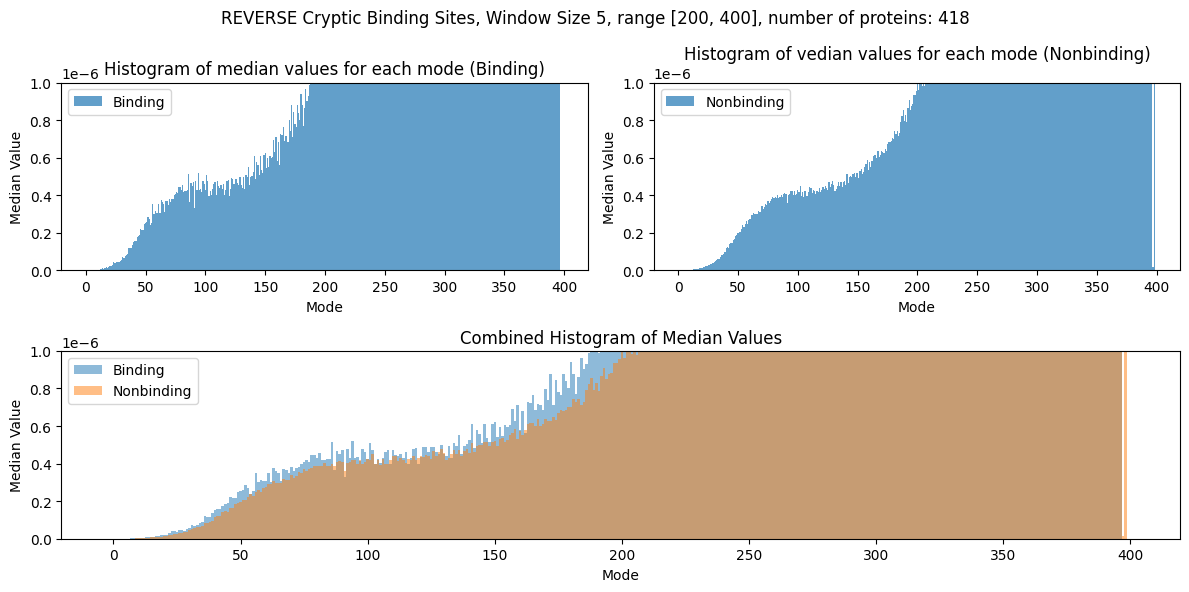

In [22]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(reverse_modes=True,range=(200, 400))
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title='REVERSE Cryptic Binding Sites, Window Size 5, range [200, 400], number of proteins: ' + str(count), limit=0.1e-05)

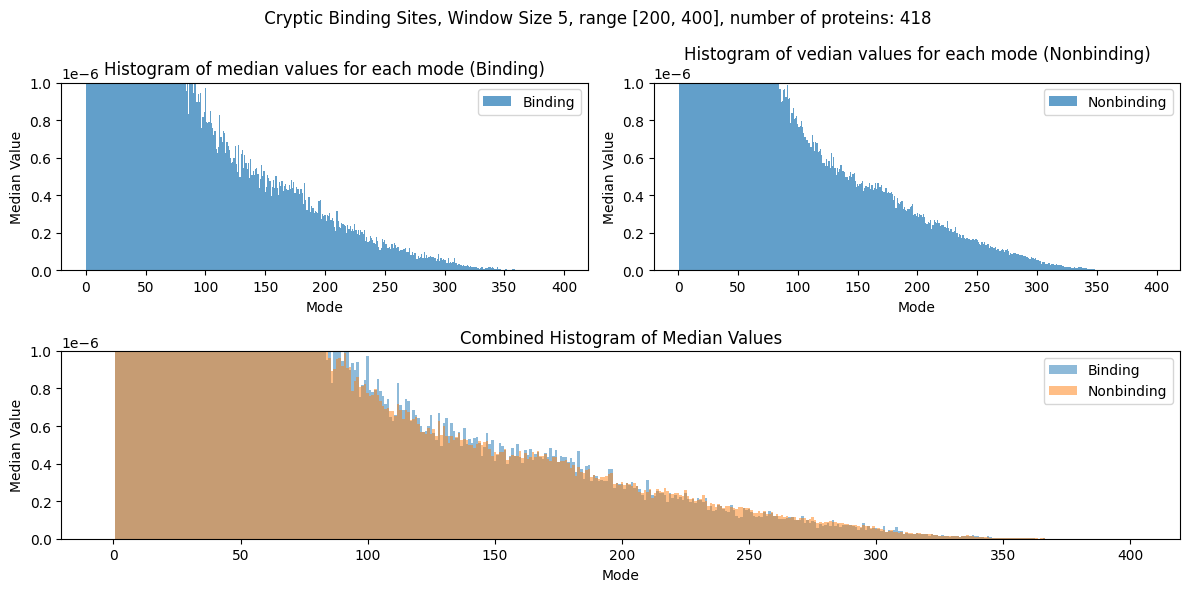

In [23]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 5
binding_data_cryptic, nonbinding_data_cryptic, count = compute_windows(range=(200, 400))
print_barcharts(binding_data_cryptic, nonbinding_data_cryptic, title=' Cryptic Binding Sites, Window Size 5, range [200, 400], number of proteins: ' + str(count), limit=0.1e-05)

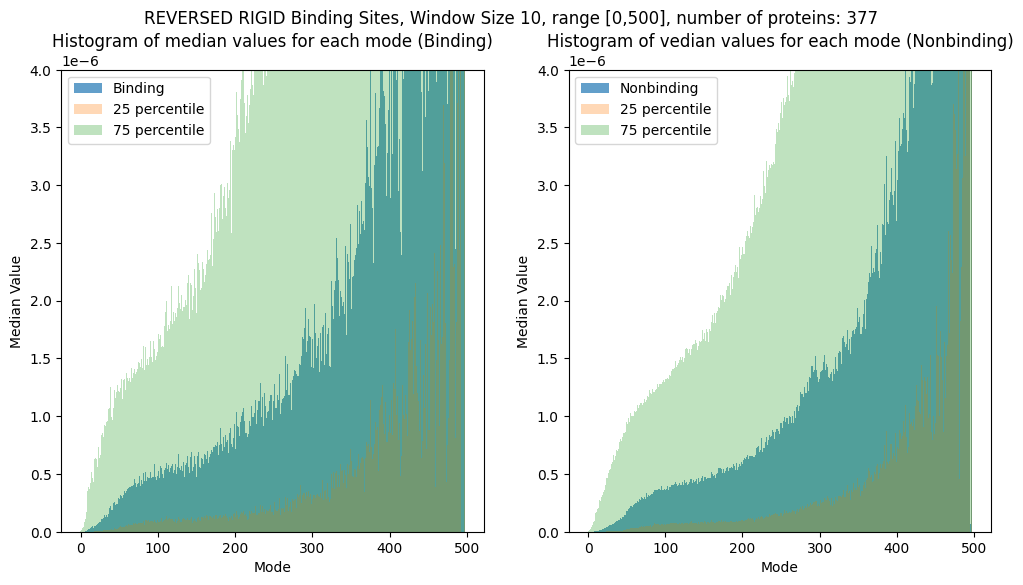

In [24]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 10
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True,range=(0, 500))
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='REVERSED RIGID Binding Sites, Window Size 10, range [0,500], number of proteins: ' + str(count), limit=4e-06)

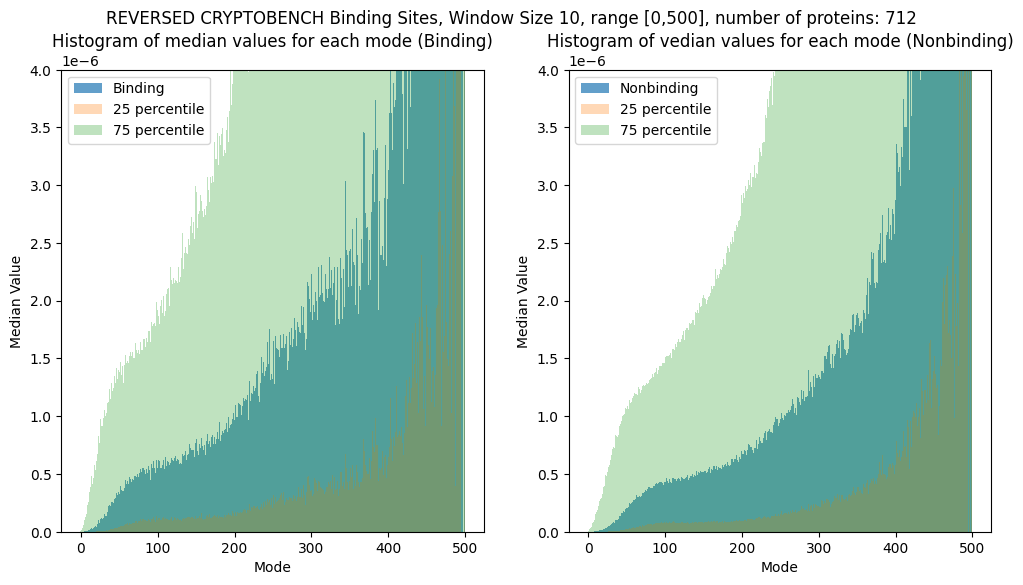

In [25]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset'
WINDOW_SIZE = 10
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True,range=(0, 500))
print_barcharts_with_variance(binding_data_rigid, nonbinding_data_rigid, title='REVERSED CRYPTOBENCH Binding Sites, Window Size 10, range [0,500], number of proteins: ' + str(count), limit=4e-06)

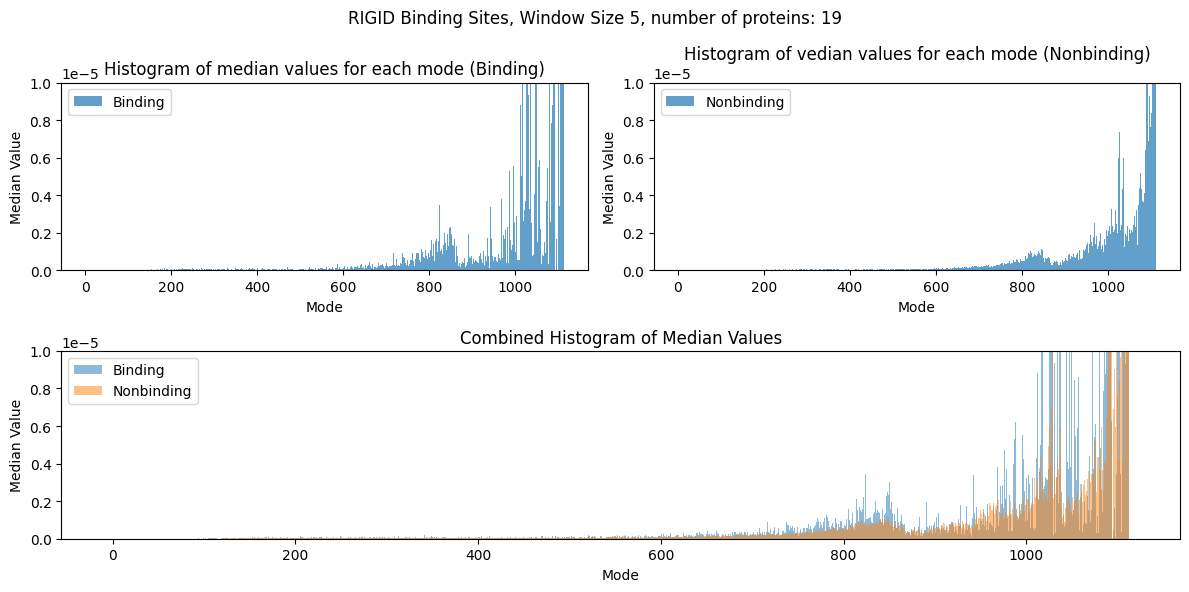

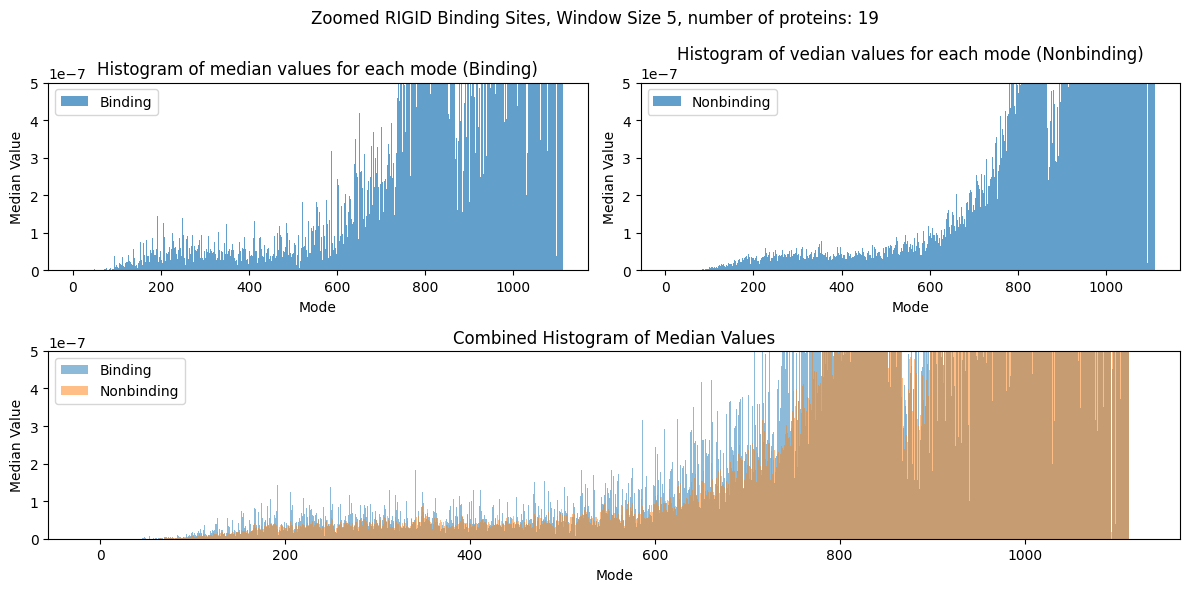

In [26]:
FLUCTUATION_PATH = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset'
WINDOW_SIZE = 5
binding_data_rigid, nonbinding_data_rigid, count = compute_windows(reverse_modes=True, range=(800, 1200))

print_barcharts(binding_data_rigid, nonbinding_data_rigid, title='RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.1e-4)
print_barcharts(binding_data_rigid, nonbinding_data_rigid, title='Zoomed RIGID Binding Sites, Window Size 5, number of proteins: ' + str(count), limit=0.5e-6)